# Inside a Molecular Dynamics Code
## Lennard-Jones molecular dynamics

This program simulates the classical dynamics of Argon atoms where the interatomic interactions are mediated by a Lennard-Jones interaction of potential and force:

$V_{LJ}(r) = 4 \epsilon [(\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6]$

$|F_{LJ}(r)| = 48 \epsilon [ \frac{\sigma^{12}}{r^{13}} - \frac{\sigma^{6}}{2r^{7}}]$

Where $\epsilon$ is the depth of the potential well and $\sigma$ is the interatomic distance at which the interaction is zero.

## Program specifications
The simulation involves:

- Initial coordinates at FCC positions.
- Periodic boundary conditions with the minimum-image criterion.
- Time integration using the [Velocity Verlet Algorithm](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet).
- A velocity rescaling thermostat.

## Outputs
The program returns the following files:
- [**FILL IN**]
- [**FILL IN**]


## Function definitions

The necessary functions are defined for the code to run:
- `pos_to_xyz()`: Writes out atomic positions to a file in the format "Ar x y z".
- `interatomic_potential()`: Returns the Lennard-Jones energy associated with a given interatomic distance in Angstrom.
- `interatomic_force()`: Same as above but returns the magnitude of the Lennard-Jones force.
- `cancelled_linear_momentum()`: Takes the velocity of each atom, and adjusts them to cancel out any overall linear momentum (drift).
- `temp_from_vel()`: Returns the temperature in Kelvin from the velocity of each atom.
- `scaled_velocities()`: Takes the velocity of each atom and a temperature, and returns the velocities scaled such that they match the temperature.

In order to extend this code to different interatomic potentials or atomic species, the functions `interatomic_potential()` and `interatomic_force()` would need to be edited, including the parameters inside.

In [1]:
"""
Simple implementation of a molecular dynamics code for a Lennard-Jones system

Inspiration is taken from a Fortran code for liquid Argon written by Alex
Pacheco on 30/01/2014 and modified by Devis Di Tommaso on 08/02/2017.  The atoms
start at FCC positions, are assigned a random velocity of magnitudes fulfilling
an initial temperature requirement, and then evolve in a cubic periodic simulation
cell according to the velocity Verlet algorithm. A scaling thermostat is applied at each step.

The units are Angstrom, seconds and kJ/mol. Note that the kJ/mol energy is that of the total cell, not per atom.
03/03/2021 - Miguel Rivera

"""
import numpy as np
import time
from itertools import combinations

### Functions

def pos_to_xyz(pos,file_name):
    with open(file_name, "a") as file_out:
        file_out.write(str(len(pos)) + "\n\n")
        # for line in pos*1e10:
        for line in pos:
            file_out.write("Ar {:9.3f} {:9.3f} {:9.3f}\n".format(line[0], line[1], line[2]))
    return


def interatomic_potential(inter_dist):
    """
    Return the energy of the van der Waals interaction given an interatomic distance

    Parameters
    ----------
    inter_dist : float
        Distance between two atoms in Angstroms
    Returns
    -------
    ener : float
        Interaction energy in kJ / mol

    """
    epsilon = 0.99363  # depth of the well in kJ/mol
    sigma = 3.405  # LJ interaction = 0 distance in A
    ener = 4 * epsilon * ((sigma / inter_dist) ** 12 - (sigma / inter_dist) ** 6)

    return ener


def interatomic_force(inter_dist):
    """
    Return the force resulting from the interatomic van der Waals interaction

    Parameters
    ----------
    inter_dist : float
        Distance between two atoms in Angstroms
    Returns
    -------
    force : float
        Magnitude of the resulting force in kJ / (mol * Angstrom)

    """
    epsilon = 0.99363  # depth of the well in kJ/mol
    sigma = 3.405  # LJ interaction = 0 distance in A
    force = (
        48
        * epsilon
        * ((sigma ** 12) / (inter_dist ** 13) - 0.5 * (sigma ** 6) / (inter_dist ** 7))
    )
    return force*0


def cancelled_linear_momentum(vel):
    """
    Set the linear momentum of a velocity array to 0

    Parameters
    ----------
    vel : N x 3 numpy array
        Initial velocities
    Returns
    -------
    vel_cancelled : N x 3 numpy array
        Velocities after cancellation

    """
    # velocity of the centre of mass
    com_vel = np.sum(vel, axis=0)
    # remove COM velocity/number of atoms from all atoms
    vel_cancelled = vel - com_vel / len(vel)

    return vel_cancelled


def temp_from_vel(vel):
    """Return temperature in T from a velocity array in A/s"""
    # Angstrom**2 to meter**2 conversion
    prefactor = 1e-20
    temperature = (
        prefactor
        * np.sum(np.linalg.norm(vel, axis=1) ** 2)
        * atomic_mass
        / (3 * g_const * n_atoms)
    )
    return temperature


def scaled_velocities(vel, temperature):
    """
    Scale a velocity vector according to a certain temperature

    Parameters
    ----------
    vel : N x 3 numpy array
        Initial velocities
    temperature : float
        Temperature in K
    Returns
    -------
    vel_scaled : N x 3 numpy array
        Scaled velocities

    """
    temp_initial = temp_from_vel(vel)
    vel_scaled = vel * np.sqrt(temperature / temp_initial)
    return vel_scaled

# [**FILL IN**]

[**FILL IN**]

In [5]:
### Main code

# parameters
n_cell = 4 # number of unit cells along one axis of the supercell
lattice_const = 5.256  # in A
box_side = n_cell * lattice_const  # side of the simulation box in A
n_steps = 500 # number of simulation steps
temp = 87.81  # in K
time_step = 2e-11  # s
atomic_mass = 39.95  # in u
g_const = 8.31446261815324e-3  # gas constant in kJ / (mol * K)
pos_file = "trajectory.xyz"
report_file = "report.csv"

### Initial positions

# cubic lattice
lattice_vectors = np.array(
    [
        [lattice_const, 0.0, 0.0],
        [0.0, lattice_const, 0.0],
        [0.0, 0.0, lattice_const],
    ]
)

# one FCC cell
fcc_pos = (
    np.array([[0.0, 0.0, 0.0], [0.5, 0.5, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5]])
    * lattice_const
)

# supercell of FCC cells
pos_i = []
for i in range(n_cell):
    for j in range(n_cell):
        for k in range(n_cell):
            # generate a translation vector
            trans_mult = np.array([i, j, k])
            trans_vec = np.sum(lattice_vectors * trans_mult, axis=1)

            # append new cell
            new_cell = fcc_pos + trans_vec
            pos_i.extend(new_cell.tolist())

pos_i = np.array(pos_i)



# [**FILL IN**]

[**FILL IN**]

In [6]:
### Assign starting velocities

# gaussian distribution number generator
n_atoms = (
    len(fcc_pos) * n_cell ** 3
)

# random seed
rng = np.random.default_rng(123456789)
vel_i = rng.standard_normal((n_atoms, 3))

# set linear momentum to 0
vel_i = cancelled_linear_momentum(vel_i)

# scale velocities according to temperature
vel_i = scaled_velocities(vel_i, temp)


# [**FILL IN**]

[**FILL IN**]

In [7]:
### Simulation loop

# start with null acceleration
acc_i = np.zeros((n_atoms, 3))

# start a output files
with open(pos_file, "w") as fname:
    pos_to_xyz(pos_i,pos_file)

with open(report_file,"w") as fname:
    fname.write("Step, Temperature, Energy\n")

# timer
start_time = time.perf_counter()

# loop each MD step
for i in range(n_steps):
    # velocity Verlet algorithm position update
    pos_f = pos_i + vel_i * time_step + (acc_i * time_step ** 2) / 2

    # apply periodic boundary conditions
    pos_f = pos_f % box_side

    # interatomic distances
    ener = 0
    force = np.zeros((n_atoms, 3))

    ## Apply potentials to the positions using numpy vectorisation
    # all pair positions
    comb = np.array(list(combinations(pos_f, 2)))

    # distance vector between each pair
    dist_vecs = comb[:, 1, :] - comb[:, 0, :]

    # periodic boundary
    dist_vecs_pbc = (dist_vecs + box_side / 2) % box_side - box_side / 2

    # array of scalar distances
    distances = np.linalg.norm(dist_vecs_pbc,axis=1)

    # calculate energies
    ener = np.sum(interatomic_potential(distances))

    # array of vector force per pair
    force_by_pair = dist_vecs_pbc / distances[:,None] * np.array(interatomic_force(distances))[:,None]

    # reshape it into a n_atoms x n_atoms (x 3) upper matrix
    force_mat = np.zeros((n_atoms,n_atoms,3))
    mask = np.triu_indices(n_atoms,k=1)
    force_mat[mask] = force_by_pair

    # add up rows and take away columns for a total
    force = np.sum(force_mat,axis=0) - np.sum(force_mat,axis=1)

    ## New velocities form forces
    # F = ma with 1e20 for Angstrom**2 to meter**2
    acc_f = force * 1e20 / atomic_mass

    # velocity update
    vel_f = vel_i + (acc_f + acc_i) / 2 * time_step

    # set linear momentum to 0
    vel_f = cancelled_linear_momentum(vel_f)

    # scale velocities according to temperature
    vel_f = scaled_velocities(vel_f, temp)

    # set up for next step
    pos_i = pos_f
    vel_i = vel_f
    acc_i = acc_f

    # print out report
    print(
        "Step : {:>4} Temperature: {:>7.3f} K Potential energy: {:>9.3f} kJ/mol".format(
            i + 1, temp_from_vel(vel_f), ener
        )
    )

    with open(report_file,"a") as fname:
        fname.write("{},{},{}\n".format(i+1,temp_from_vel(vel_f),ener))

    # print out new goemetry
    pos_to_xyz(pos_f, "trajectory.xyz")

# timer
end_time = time.perf_counter()
print("Run time: {:>8.4f} s.".format(end_time - start_time))

Step :    1 Temperature:  87.810 K Potential energy: -2131.290 kJ/mol
Step :    2 Temperature:  87.810 K Potential energy: -2104.889 kJ/mol
Step :    3 Temperature:  87.810 K Potential energy: -2058.124 kJ/mol
Step :    4 Temperature:  87.810 K Potential energy: -1987.122 kJ/mol
Step :    5 Temperature:  87.810 K Potential energy: -1886.055 kJ/mol
Step :    6 Temperature:  87.810 K Potential energy: -1746.528 kJ/mol
Step :    7 Temperature:  87.810 K Potential energy: -1556.662 kJ/mol
Step :    8 Temperature:  87.810 K Potential energy: -1299.743 kJ/mol
Step :    9 Temperature:  87.810 K Potential energy:  -952.254 kJ/mol
Step :   10 Temperature:  87.810 K Potential energy:  -481.000 kJ/mol
Step :   11 Temperature:  87.810 K Potential energy:   161.050 kJ/mol
Step :   12 Temperature:  87.810 K Potential energy:  1040.792 kJ/mol
Step :   13 Temperature:  87.810 K Potential energy:  2253.677 kJ/mol
Step :   14 Temperature:  87.810 K Potential energy:  3936.259 kJ/mol
Step :   15 Temperat

Step :  114 Temperature:  87.810 K Potential energy: 165808173877842.938 kJ/mol
Step :  115 Temperature:  87.810 K Potential energy: 23842482590527.594 kJ/mol
Step :  116 Temperature:  87.810 K Potential energy: 4512256834527.999 kJ/mol
Step :  117 Temperature:  87.810 K Potential energy: 1213959564979.770 kJ/mol
Step :  118 Temperature:  87.810 K Potential energy: 485574717202.186 kJ/mol
Step :  119 Temperature:  87.810 K Potential energy: 246231472213.400 kJ/mol
Step :  120 Temperature:  87.810 K Potential energy: 144504536055.071 kJ/mol
Step :  121 Temperature:  87.810 K Potential energy: 172182088300.830 kJ/mol
Step :  122 Temperature:  87.810 K Potential energy: 725539920919.329 kJ/mol
Step :  123 Temperature:  87.810 K Potential energy: 4900838014859.118 kJ/mol
Step :  124 Temperature:  87.810 K Potential energy: 33642884265110.961 kJ/mol
Step :  125 Temperature:  87.810 K Potential energy: 160857617197097.062 kJ/mol
Step :  126 Temperature:  87.810 K Potential energy: 3109188167

Step :  222 Temperature:  87.810 K Potential energy: 167982242304.424 kJ/mol
Step :  223 Temperature:  87.810 K Potential energy: 248494801600.765 kJ/mol
Step :  224 Temperature:  87.810 K Potential energy: 423888008230.598 kJ/mol
Step :  225 Temperature:  87.810 K Potential energy: 878796631071.902 kJ/mol
Step :  226 Temperature:  87.810 K Potential energy: 2641915272163.792 kJ/mol
Step :  227 Temperature:  87.810 K Potential energy: 11920311132776.137 kJ/mol
Step :  228 Temperature:  87.810 K Potential energy: 71960441878663.984 kJ/mol
Step :  229 Temperature:  87.810 K Potential energy: 536422173231047.188 kJ/mol
Step :  230 Temperature:  87.810 K Potential energy: 4552085361924774.000 kJ/mol
Step :  231 Temperature:  87.810 K Potential energy: 36058236143399576.000 kJ/mol
Step :  232 Temperature:  87.810 K Potential energy: 207594324939737760.000 kJ/mol
Step :  233 Temperature:  87.810 K Potential energy: 326686536586660160.000 kJ/mol
Step :  234 Temperature:  87.810 K Potential en

Step :  330 Temperature:  87.810 K Potential energy: 52496093954785.047 kJ/mol
Step :  331 Temperature:  87.810 K Potential energy: 2479770153243.424 kJ/mol
Step :  332 Temperature:  87.810 K Potential energy: 309949890705.580 kJ/mol
Step :  333 Temperature:  87.810 K Potential energy: 1290568747457.911 kJ/mol
Step :  334 Temperature:  87.810 K Potential energy: 10291040394098.746 kJ/mol
Step :  335 Temperature:  87.810 K Potential energy: 97236461616799.969 kJ/mol
Step :  336 Temperature:  87.810 K Potential energy: 836633342036867.875 kJ/mol
Step :  337 Temperature:  87.810 K Potential energy: 3500953258606853.500 kJ/mol
Step :  338 Temperature:  87.810 K Potential energy: 3318239374787774.500 kJ/mol
Step :  339 Temperature:  87.810 K Potential energy: 743215709575690.250 kJ/mol
Step :  340 Temperature:  87.810 K Potential energy: 97496425432456.750 kJ/mol
Step :  341 Temperature:  87.810 K Potential energy: 29041955732433.180 kJ/mol
Step :  342 Temperature:  87.810 K Potential energ

Step :  438 Temperature:  87.810 K Potential energy: 27842512364237.445 kJ/mol
Step :  439 Temperature:  87.810 K Potential energy: 341244608920190.438 kJ/mol
Step :  440 Temperature:  87.810 K Potential energy: 4822719644329148.000 kJ/mol
Step :  441 Temperature:  87.810 K Potential energy: 42297233555740528.000 kJ/mol
Step :  442 Temperature:  87.810 K Potential energy: 67621140473378104.000 kJ/mol
Step :  443 Temperature:  87.810 K Potential energy: 13454696126619284.000 kJ/mol
Step :  444 Temperature:  87.810 K Potential energy: 1098309199714423.500 kJ/mol
Step :  445 Temperature:  87.810 K Potential energy: 2711553527125732.500 kJ/mol
Step :  446 Temperature:  87.810 K Potential energy: 341444063469265728.000 kJ/mol
Step :  447 Temperature:  87.810 K Potential energy: 75385865095173799936.000 kJ/mol
Step :  448 Temperature:  87.810 K Potential energy: 31756985620156325888.000 kJ/mol
Step :  449 Temperature:  87.810 K Potential energy: 120768954081823696.000 kJ/mol
Step :  450 Temp

## Log
Log your activity here, feel free to write in your own style as if this were a physical lab book.
- **14/03/-44**: Conversation about policy with labmate Brutus
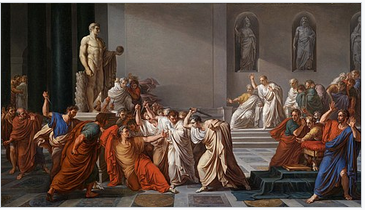
- [**FILL IN**]

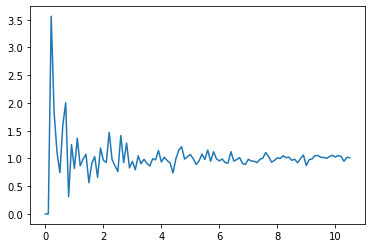

In [8]:
def rdf(pos,dr):
    """
    Return a radial distribution

    Arguments
    ---------
    pos : N x 3 numpy array
        Cartesian coordinates
    dr : float
        Radius step size between 0 and box_side length in Angstrom
    Returns
    -------
    x_range : numpy array
        X coordinate of the beginning of each bin
    left_bin_edges : numpy array
        Normalised count of interatomic distances within the bin. The normalisation is by the volume of the shell.

    """
    x_range = np.arange(0, box_side+dr, dr)

    # all distances with no double counting
    comb = np.array(list(combinations(pos, 2)))
    dist_vecs = comb[:, 1, :] - comb[:, 0, :]
    dist_vecs_pbc = (dist_vecs + box_side / 2) % box_side - box_side / 2
    distances = np.linalg.norm(dist_vecs_pbc,axis=1)

    # sort counts in a histogram
    counts, tmp_range = np.histogram(distances, x_range)
    left_bin_edges = x_range[:-1]

    # normalise by number of distances and particle density
    norm_counts = 2*counts/(((left_bin_edges+dr)**3 - left_bin_edges**3)* 4*np.pi/3 * n_atoms**2/box_side**3)

    # only return first half of the data, the latter is ruined by PBC
    return left_bin_edges[:round(len(left_bin_edges)/2)], norm_counts[:round(len(norm_counts)/2)]

# calculate the radial distribution function
dr = 0.1
rdf_distance, radial_density = rdf(pos_f,dr)
with open("rdf.csv","w") as rdf_file:
    rdf_file.write("Distance (Å),Density\n")
    for i,j in zip(rdf_distance, radial_density):
        rdf_file.write("{},{}\n".format(i,j))
        
# plot the result
import matplotlib.pyplot as plt
plt.plot(rdf_distance, radial_density)
plt.savefig("rdf.png")